In [12]:
import json
import pandas as pd
from pathlib import Path
# name_file = 'prototypes/merged_inference_stats_7x7_color_tymek'
name_file = '../explanations10_new_results_NO_EPIC/merged_inference_stats'
in_path = Path(f"{name_file}.json")      # <-- set to your path
out_path = Path(f"{name_file}.csv") # output CSV path

with in_path.open("r") as f:
    data = json.load(f)

rows = []
for sample_name, channels in data.items():
    parts = sample_name.split("_")
    class_name = "_".join(parts[:-1]) if len(parts) > 1 else sample_name
    id_number = parts[-1] if len(parts) > 1 else ""
    
    for ch, info in channels.items():
        channel_str = str(ch).zfill(4)
        classes = info.get("classes", [])
        samples = info.get("samples", [])

        n = len(classes)
        for r in range(1, n + 1):
            predicted_class = classes[r - 1]
            samples_inside = samples[r - 1]

            rows.append({
                "class_name": class_name,
                "id_number": id_number,
                "sample_name": sample_name,
                "rank": r,
                "channel": channel_str,
                "prototype_class": predicted_class,
                "samples": samples_inside
            })

df = pd.DataFrame(rows, columns=["class_name", "id_number", "sample_name", "rank", "channel", "prototype_class", 'samples'])
df.to_csv(out_path, index=False)
print(f"Wrote {len(df)} rows to {out_path}")


Wrote 450 rows to ../explanations10_new_results_NO_EPIC/merged_inference_stats.csv


In [13]:
df.head(10)

,class_name,id_number,sample_name,rank,channel,prototype_class,samples
0,glass,012,glass_012,1,0201,6,61
1,glass,012,glass_012,2,0201,6,62
2,glass,012,glass_012,3,0201,6,64
3,glass,012,glass_012,4,0201,10,1
4,glass,012,glass_012,5,0201,2,11
5,glass,012,glass_012,1,0233,6,62
6,glass,012,glass_012,2,0233,6,59
7,glass,012,glass_012,3,0233,6,60
8,glass,012,glass_012,4,0233,6,64
9,glass,012,glass_012,5,0233,6,54


In [14]:
df['prototype_class'].value_counts()

prototype_class
3     76
6     62
10    60
7     55
2     50
9     45
8     40
4     35
5     27
Name: count, dtype: int64

In [15]:
print(df)

    class_name id_number   sample_name  rank channel prototype_class  samples
0        glass       012     glass_012     1    0201               6       61
1        glass       012     glass_012     2    0201               6       62
2        glass       012     glass_012     3    0201               6       64
3        glass       012     glass_012     4    0201              10        1
4        glass       012     glass_012     5    0201               2       11
..         ...       ...           ...   ...     ...             ...      ...
445   dinosaur       001  dinosaur_001     1    0221               4       31
446   dinosaur       001  dinosaur_001     2    0221               5       44
447   dinosaur       001  dinosaur_001     3    0221               8       81
448   dinosaur       001  dinosaur_001     4    0221               4       32
449   dinosaur       001  dinosaur_001     5    0221               8       86

[450 rows x 7 columns]


In [16]:
df.groupby('class_name')["prototype_class"].value_counts()

class_name  prototype_class
cup         2                  32
            6                   9
            5                   3
            7                   3
            8                   2
            9                   1
deer_moose  3                  46
            4                   2
            5                   2
dinosaur    4                  28
            5                  10
            8                   8
            10                  4
fox         3                  30
            5                   9
            2                   6
            10                  3
            4                   2
glass       6                  35
            10                 10
            2                   4
            7                   1
hat         7                  43
            4                   3
            8                   3
            2                   1
monitor     8                  26
            6                   8
            2       

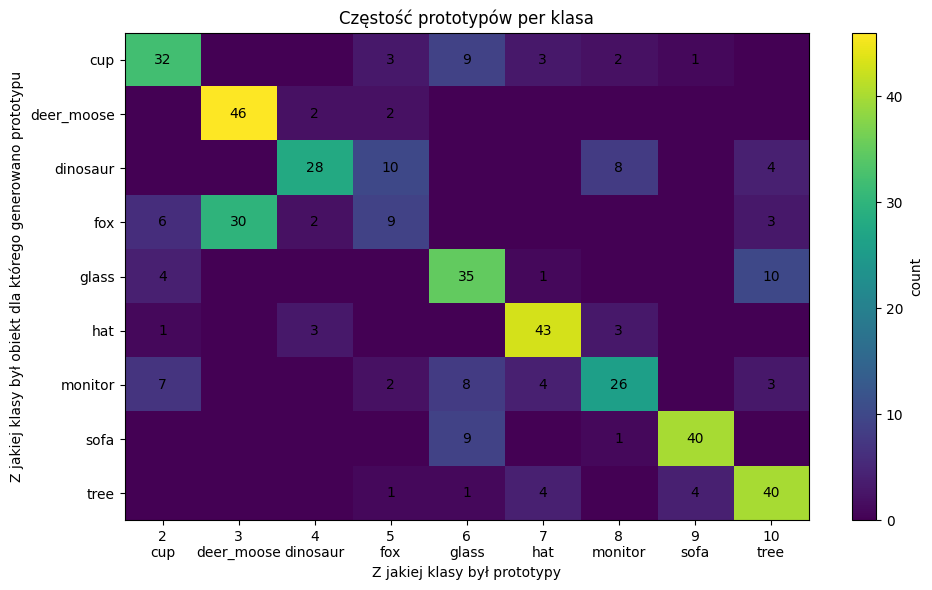

Tablica kształt: (9, 9)
Kolumny (ID): [2, 3, 4, 5, 6, 7, 8, 9, 10]


In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# --- START: przygotowanie danych ---

# Upewnij się, że prototype_class jest liczbą całkowitą
df = df.copy()
df["prototype_class"] = pd.to_numeric(df["prototype_class"], errors="coerce").astype("Int64")

# Zbuduj tablicę zliczeń: wiersze=class_name, kolumny=prototype_class (ID)
ct = pd.crosstab(df["class_name"], df["prototype_class"])

# Wymuś pełny zakres kolumn 2..10 i wypełnij zera tam gdzie brak
all_ids = [2,3,4,5,6,7,8,9,10]
ct = ct.reindex(columns=all_ids, fill_value=0)

# Opcjonalnie posortuj klasy alfabetycznie
ct = ct.sort_index()

# --- END: przygotowanie danych ---

# Mapowanie ID -> nazwa
id_to_name = {
    2: "cup",
    3: "deer_moose",
    4: "dinosaur",
    5: "fox",
    6: "glass",
    7: "hat",
    8: "monitor",
    9: "sofa",
    10: "tree"
}

# Etykiety X: pokaż ID i nazwę (czytelniej)
x_labels = [f"{i}\n{id_to_name.get(i, str(i))}" for i in all_ids]

# Macierz do rysowania
M = ct.values  # shape: (n_classes, 9)

# --- RYSOWANIE MATPLOTLIB (bez seaborn) ---
fig, ax = plt.subplots(figsize=(10, 6))
im = ax.imshow(M, aspect="auto")  # nie ustawiamy kolorów ręcznie

# Ticki i etykiety
ax.set_xticks(np.arange(ct.shape[1]))
ax.set_xticklabels(x_labels, rotation=0, ha="center")
ax.set_yticks(np.arange(ct.shape[0]))
ax.set_yticklabels(ct.index)

ax.set_xlabel("Z jakiej klasy był prototypy")
ax.set_ylabel("Z jakiej klasy był obiekt dla którego generowano prototypu")
ax.set_title("Częstość prototypów per klasa")

# Pasek kolorów
cbar = plt.colorbar(im, ax=ax)
cbar.set_label("count")

# Adnotacje liczbami (jeśli chcesz, możesz wyłączyć pętlę)
for i in range(M.shape[0]):
    for j in range(M.shape[1]):
        v = int(M[i, j])
        if v > 0:
            ax.text(j, i, str(v), ha="center", va="center")

plt.tight_layout()
plt.show()

# Diagnostyka, gdyby coś dalej nie grało:
print("Tablica kształt:", ct.shape)
print("Kolumny (ID):", list(ct.columns))


In [18]:
from IPython.display import display, HTML

a = df.groupby('class_name')["channel"].value_counts()
display(HTML(f"<div style='height:300px; overflow:auto;'>{a.to_frame().to_html()}</div>"))


In [19]:
df

,class_name,id_number,sample_name,rank,channel,prototype_class,samples
0,glass,012,glass_012,1,0201,6,61
1,glass,012,glass_012,2,0201,6,62
2,glass,012,glass_012,3,0201,6,64
3,glass,012,glass_012,4,0201,10,1
4,glass,012,glass_012,5,0201,2,11
...,...,...,...,...,...,...,...
445,dinosaur,001,dinosaur_001,1,0221,4,31
446,dinosaur,001,dinosaur_001,2,0221,5,44
447,dinosaur,001,dinosaur_001,3,0221,8,81
448,dinosaur,001,dinosaur_001,4,0221,4,32


In [20]:
most_frequent = list(df['samples'].value_counts().items())[:10]



In [21]:
for sample, count in most_frequent:
    print(f"Sample: {sample}, Count: {count}")
    print(df[df['samples'] == sample]['channel'].value_counts())
    print('\n')
    print(df[df['samples'] == sample]['prototype_class'].value_counts())
    print('\n')

    print(df[df['samples'] == sample]['class_name'].value_counts())

    print("-----")

# print(len(df[df['samples'].isin(most_frequent)]))
# df[df['samples'].isin(most_frequent)]['prototype_class'].value_counts()

Sample: 3, Count: 17
channel
0058    2
0011    2
0197    2
0082    2
0067    2
0074    2
0006    1
0025    1
0204    1
0221    1
0163    1
Name: count, dtype: int64


prototype_class
10    17
Name: count, dtype: Int64


class_name
tree        10
glass        3
dinosaur     2
fox          1
monitor      1
Name: count, dtype: int64
-----
Sample: 64, Count: 15
channel
0118    3
0201    2
0220    2
0233    2
0058    2
0149    2
0059    1
0120    1
Name: count, dtype: int64


prototype_class
6    15
Name: count, dtype: Int64


class_name
glass      9
cup        2
monitor    2
sofa       2
Name: count, dtype: int64
-----
Sample: 18, Count: 15
channel
0200    3
0103    3
0021    3
0189    3
0126    2
0093    1
Name: count, dtype: int64


prototype_class
3    15
Name: count, dtype: Int64


class_name
deer_moose    10
fox            5
Name: count, dtype: int64
-----
Sample: 26, Count: 15
channel
0200    3
0103    3
0021    3
0189    3
0126    2
0045    1
Name: count, dtype: int64


prototype_cl